In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import chi2_contingency

In [5]:
df = pd.read_csv('data_A.csv')
df

,Муниципалитет,Предмет,Этап,Год,Количество участников,Этап_порядок
0,Новгородский район,Математика,М,2024,269,1
1,Боровичский район,Математика,М,2024,423,1
2,Валдайский район,Математика,М,2024,207,1
3,Крестецкий район,Математика,М,2024,259,1
4,Любытинский район,Математика,М,2024,280,1
...,...,...,...,...,...,...
1003,Мошенской район,Информатика,З,2022,4,3
1004,Батецкий район,Информатика,З,2022,12,3
1005,Демянский район,Информатика,З,2022,2,3
1006,Холмский район,Информатика,З,2022,1,3


# 1. Анализ основных свойств данных

## 1.1 Расчет статистических характеристик данных

Статистические хар-ки числовых данных

In [9]:
df.describe()

,Год,Количество участников,Этап_порядок
count,1008.000000,1008.000000,1008.000000
mean,2023.000000,162.860119,1.500000
std,0.816902,158.178482,1.118589
min,2022.000000,0.000000,0.000000
25%,2022.000000,23.000000,0.750000
50%,2023.000000,97.500000,1.500000
75%,2024.000000,287.000000,2.250000
max,2024.000000,864.000000,3.000000


Данные охватывают 2022–2024 годы с медианой участников 97.5 и равномерным распределением этапов (медиана 1.5), при этом количество участников сильно варьируется, достигая 864 человек.

Статистические хар-ки категориальных данных

In [12]:
cat_cols = df.select_dtypes('object').columns

for col in cat_cols:
    stats = df[col].value_counts()


    print(f'\n---{col}---')
    print(f"\nЧастоты: {stats}")
    print(f"Мода: {df[col].mode()[0]}")
    print(f"Всего значений: {df[col].nunique()}")
    print(f"Самое редкое значение: {stats.idxmin()}")
    print(f"Доля уникальных значений: {df[col].nunique() / len(df[col]):.4f}")


---Муниципалитет---

Частоты: Муниципалитет
Новгородский район     48
Поддорский район       48
Холмский район         48
Демянский район        48
Батецкий район         48
Мошенской район        48
Чудовский район        48
Хвойнинский район      48
Старорусский район     48
Солецкий район         48
Чупский район          48
Боровичский район      48
Чеховский район        48
Шимский район          48
Окуловский район       48
Пестовский район       48
Маловишерский район    48
Любытинский район      48
Крестецкий район       48
Валдайский район       48
Волотовский район      48
Name: count, dtype: int64
Мода: Батецкий район
Всего значений: 21
Самое редкое значение: Новгородский район
Доля уникальных значений: 0.0208

---Предмет---

Частоты: Предмет
Математика         252
Английский язык    252
Физика             252
Информатика        252
Name: count, dtype: int64
Мода: Английский язык
Всего значений: 4
Самое редкое значение: Математика
Доля уникальных значений: 0.0040

---Этап--

"Муниципалитет" имеет большее разнообразие (21 значение) с равномерным распределением, а "Предмет" и "Этап" — низкое разнообразие (по 4 значения) и полную однородность данных.

## 1.2 Распределение

In [15]:
df_num = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)
df_num.head()

,Муниципалитет,Предмет,Этап,Год,Количество участников,Этап_порядок
0,0,0,0,2024,269,1
1,1,0,0,2024,423,1
2,2,0,0,2024,207,1
3,3,0,0,2024,259,1
4,4,0,0,2024,280,1


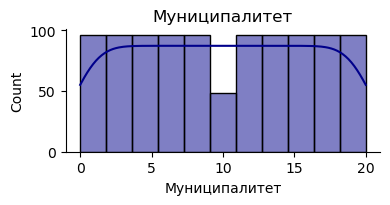

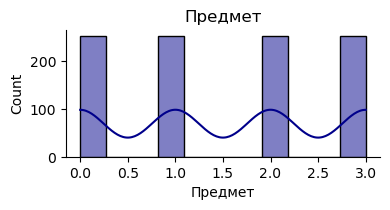

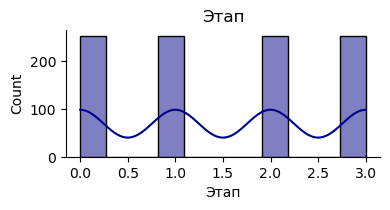

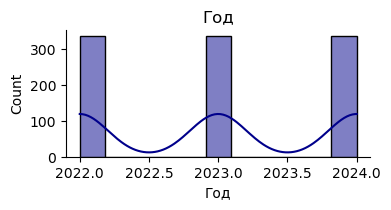

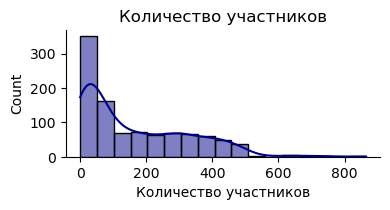

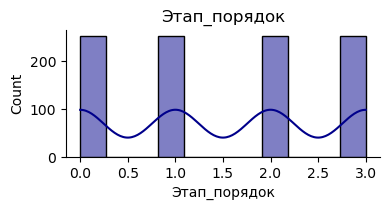

In [16]:
for column in df_num.columns:
    sns.displot(df_num[column], kde=True, color='darkblue', height=2, aspect=2)
    plt.title(column)
    plt.show()

## 1.3 Корреляция

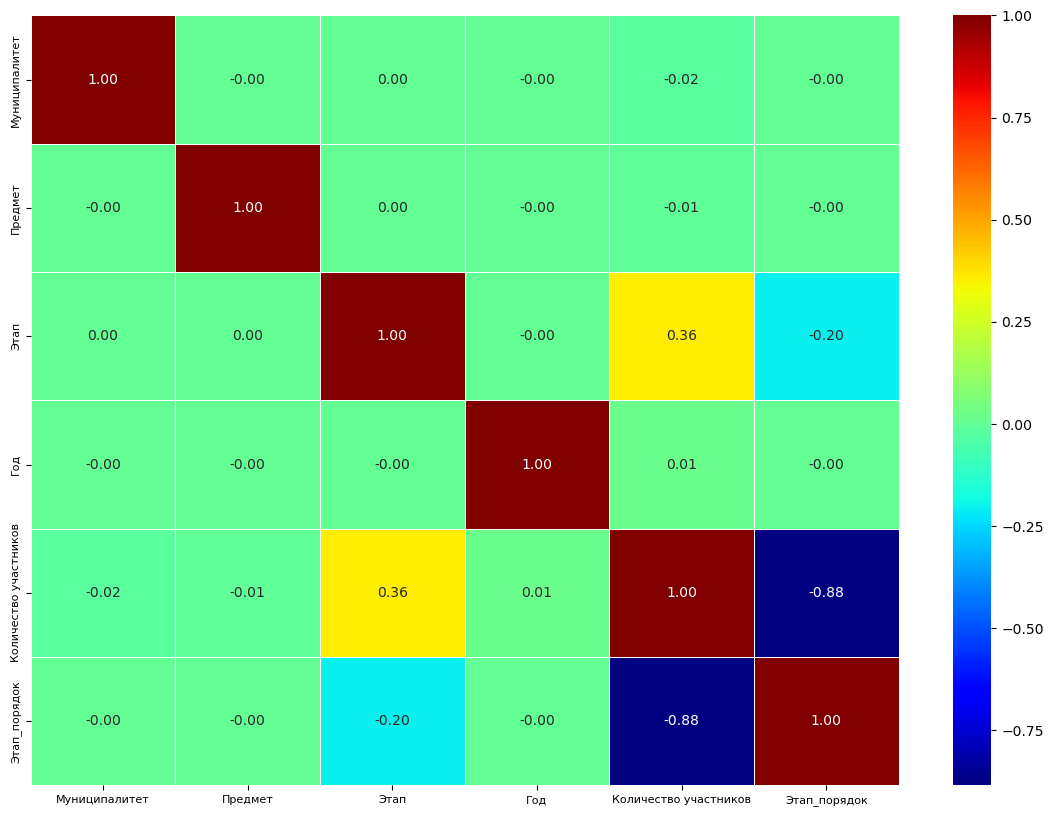

In [60]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_num.corr(), annot=True, cmap='jet', fmt='.2f', linewidths=0.5)
plt.xticks(rotation=0, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.show()

Количество участников уменьшается с увеличением значения Этап_порядок (-0.88), с большим участием на начальных этапах (0.36), что отражает четкую зависимость, подтверждаемую слабой связью (-0.20) между порядком и значением этапа.

# 2. Закономерности и зависимости

## 2.1 Закономерности

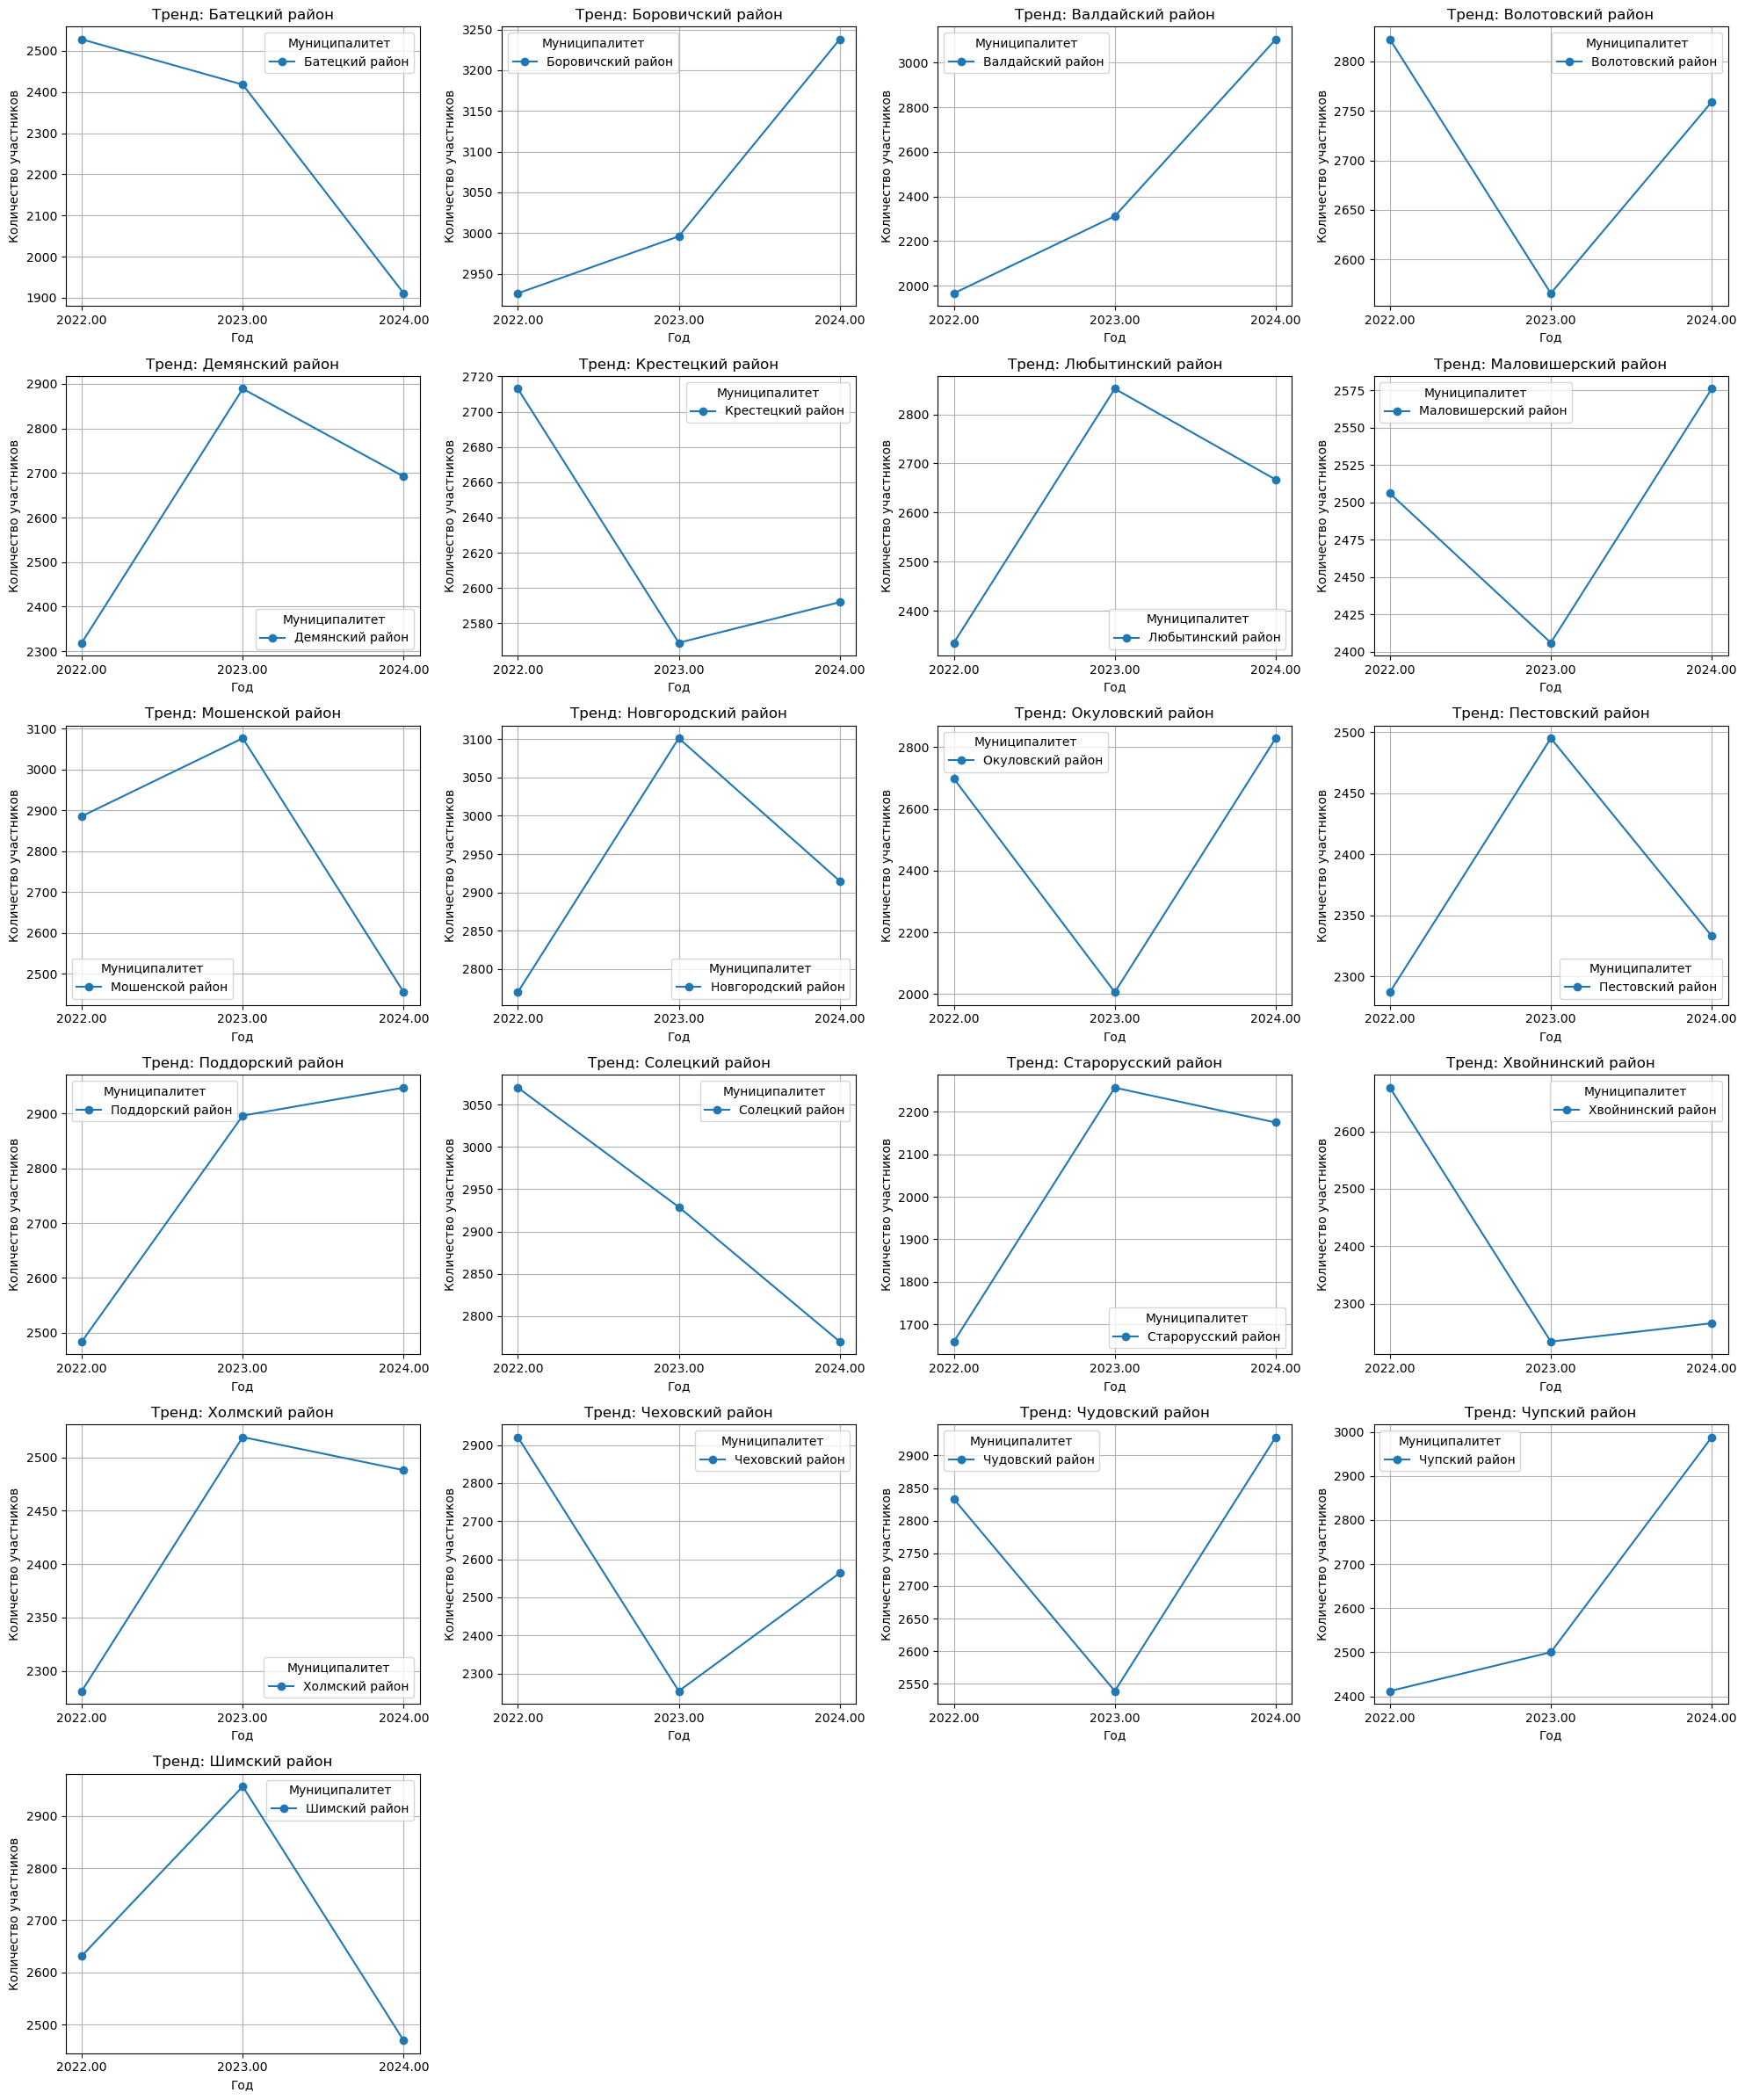

In [90]:
import matplotlib.pyplot as plt
import math

# Группировка и агрегация данных
df_grouped = df.groupby(['Муниципалитет', 'Год'])['Количество участников'].sum().reset_index()

# Уникальные муниципалитеты
municipalities = df_grouped['Муниципалитет'].unique()

# Настраиваем количество графиков на строку и вычисляем размер сетки
cols = 4  # Количество графиков в строке
rows = math.ceil(len(municipalities) / cols)  # Количество строк в сетке

# Создание сетки графиков
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Преобразуем axes в одномерный массив для удобства

# Итерация по муниципалитетам и осям
for ax, municipality in zip(axes, municipalities):
    # Фильтрация данных для текущего муниципалитета
    municipality_data = df_grouped[df_grouped['Муниципалитет'] == municipality]
    
    # Построение графика
    ax.plot(municipality_data['Год'], municipality_data['Количество участников'], marker='o', label=municipality)
    
    # Настройки графика
    ax.set_title(f'Тренд: {municipality}')
    ax.set_xlabel('Год')
    ax.set_ylabel('Количество участников')
    ax.legend(title='Муниципалитет')
    ax.grid(True)
    
    # Настройка оси X для отображения только целых годов
    years = municipality_data['Год'].unique()
    ax.set_xticks(years)  # Устанавливаем метки на оси X
    ax.set_xticklabels([f"{int(year)}.00" for year in years])  # Форматируем метки

# Удаление лишних осей, если количество муниципалитетов не кратно cols
for ax in axes[len(municipalities):]:
    ax.remove()

# Автоматическая подгонка layout
plt.tight_layout()
plt.show()

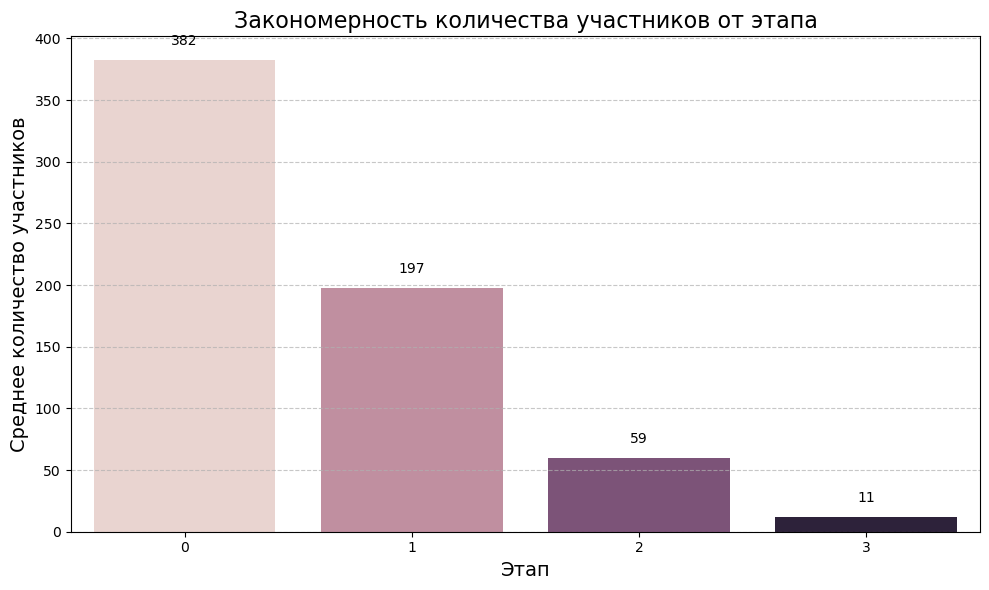

In [92]:
# Группируем данные по этапам и считаем среднее количество участников
df_grouped_stage = df.groupby('Этап_порядок')['Количество участников'].mean().reset_index()

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Этап_порядок', y='Количество участников', hue='Этап_порядок', data=df_grouped_stage, legend=False)
plt.title('Закономерность количества участников от этапа', fontsize=16)
plt.xlabel('Этап', fontsize=14)
plt.ylabel('Среднее количество участников', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений на столбцы
for index, value in enumerate(df_grouped_stage['Количество участников']):
    plt.text(index, value + 10, f'{int(value)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Снижение количества участников с каждым этапом может указывать на отбор, при котором к следующему этапу допускаются наиболее успешные участники, что приводит к уменьшению их общего числа.

## 2.2 Зависимости

### 2.20 Зависимости категориальных переменных с числовыми

In [28]:
obj_columns = df.select_dtypes('object').columns
num_columns = df.select_dtypes('number').columns

mi_score = pd.DataFrame(index=obj_columns, columns=num_columns)

for obj_column in obj_columns:
    for num_column in num_columns:
        try:
            mi_score.loc[obj_column, num_column] = mutual_info_regression(df[[num_column]], df[obj_column].astype('category').cat.codes)[0]
        except:
            mi_score.loc[obj_column, num_column] = np.nan

mi_score

,Год,Количество участников,Этап_порядок
Муниципалитет,0,0.01145,0
Предмет,0.008819,0,0.061046
Этап,0,1.172432,1.400136


**Этап** демонстрирует сильную связь с количеством участников и порядком этапа, что подчеркивает его **важность в данных**. В то же время **муниципалитет** и **предмет** практически не влияют на числовые переменные, что указывает на их **незначительную роль в данном анализе**.

### 2.21 Зависимости категориальных переменных

<Axes: >

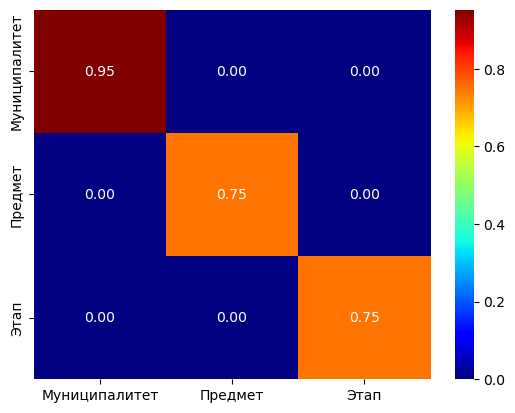

In [31]:
def theta_goodman_kruskal(x, y):
    contingency_table = pd.crosstab(x, y)
    total = contingency_table.values.sum()
    max_without_x = contingency_table.sum(axis=0).max()
    max_with_x = sum(contingency_table.max(axis=1))
    theta = (max_with_x - max_without_x) / total
    return theta

# Матрица Тета Гудмана и Крускала
matrix = pd.DataFrame(
    [[theta_goodman_kruskal(df[col1], df[col2]) for col1 in obj_columns] for col2 in obj_columns],
    index=obj_columns, columns=obj_columns
)

sns.heatmap(matrix, cmap='jet', annot=True, fmt=".2f", cbar=True)

Между всеми парами переменных, кроме их связи самих с собой, отсутствует взаимосвязь (все коэффициенты равны 0.0), т.е. **переменные в данной выборке независимы друг от друга.**

### 2.3 Тенденция развития олимпиадного движения в регионе

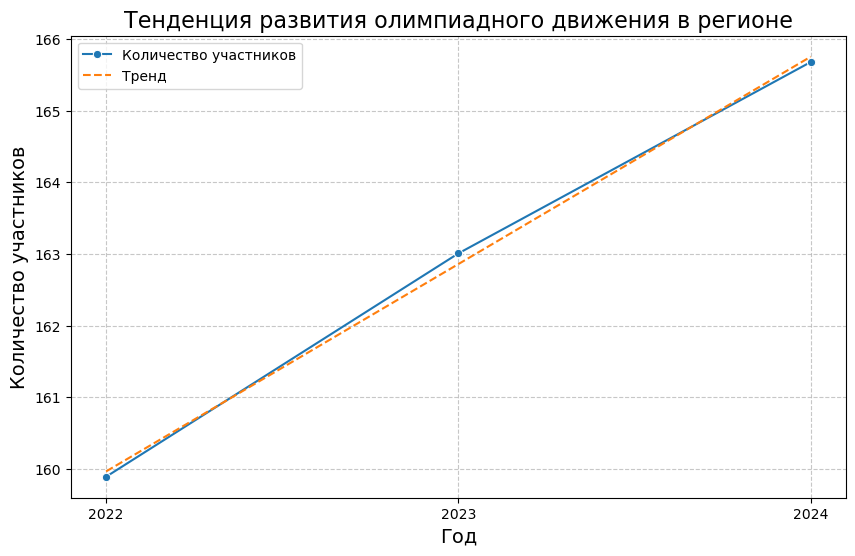

In [34]:
df_grouped_year = df.groupby('Год')['Количество участников'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Год', y='Количество участников', data=df_grouped_year, marker='o', label='Количество участников')

# Добавление линии тренда
z = np.polyfit(df_grouped_year['Год'], df_grouped_year['Количество участников'], 1)
p = np.poly1d(z)
plt.plot(df_grouped_year['Год'], p(df_grouped_year['Год']), '--', label='Тренд')

# Форматирование оси X
plt.xticks(df_grouped_year['Год'])

plt.title('Тенденция развития олимпиадного движения в регионе', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество участников', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Количество участников олимпиад увеличивается с каждым годом, что свидетельствует о росте интереса и развитии олимпиадного движения в регионе.

## 2.4 Точность прогноза

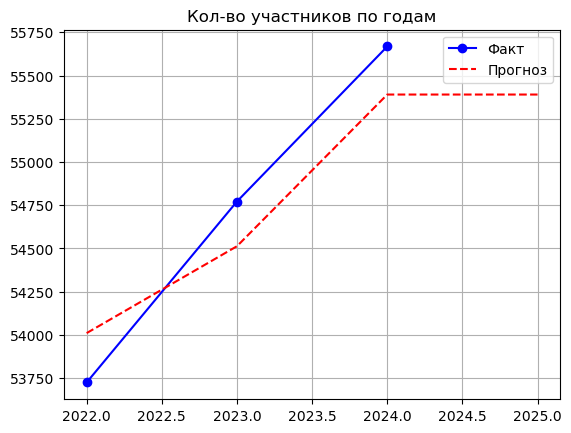

In [37]:
a = df.groupby('Год')['Количество участников'].sum()

def forest(data, title):
    X = data.index.values.reshape(-1, 1)
    y = data.values

    model = RandomForestRegressor(n_estimators=100)
    model.fit(X, y)

    future_years = np.arange(X.min(), X.max() + 2).reshape(-1, 1)
    pred = model.predict(future_years)

    plt.plot(data.index, data.values, 'bo-', label='Факт')
    plt.plot(future_years, pred, 'r--', label='Прогноз')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

forest(a, 'Кол-во участников по годам')

Прогноз демонстрирует высокую точность, так как он следует за фактическими данными и корректно отражает тенденцию роста количества участников.

# 3. Проверка на нормальность распределения

Этап М: Statistic=0.929, p-value=0.000
Распределение в 'Количество участников' для этапа М ненормальное.



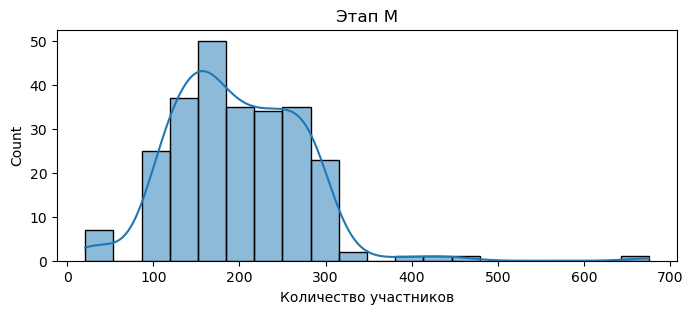

Этап Р: Statistic=0.982, p-value=0.003
Распределение в 'Количество участников' для этапа Р ненормальное.



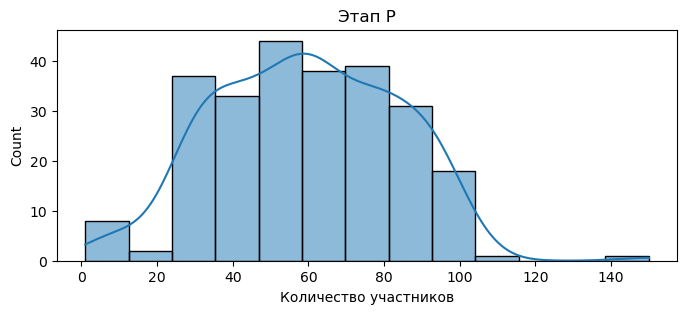

Этап З: Statistic=0.959, p-value=0.000
Распределение в 'Количество участников' для этапа З ненормальное.



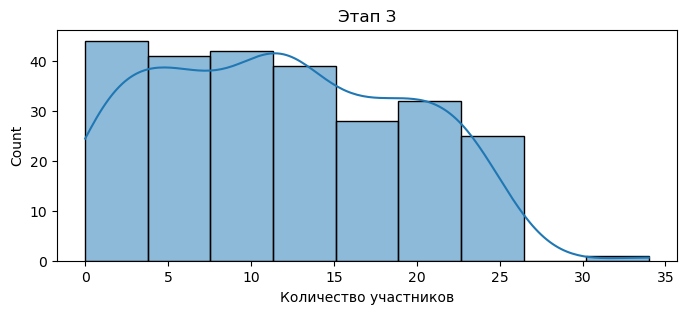

Этап Ш: Statistic=0.940, p-value=0.000
Распределение в 'Количество участников' для этапа Ш ненормальное.



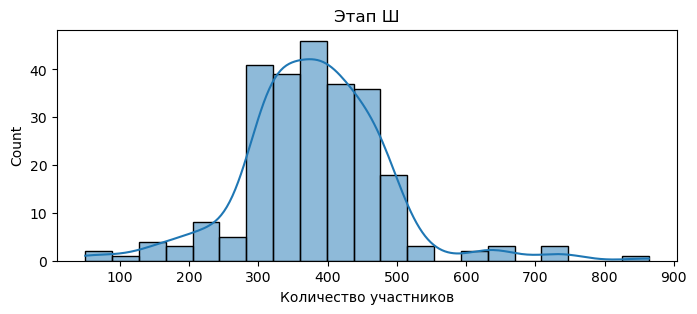

In [68]:
for stage in df['Этап'].unique():
    stage_data = df[df['Этап'] == stage]['Количество участников'].dropna()
    stat, p = stats.shapiro(stage_data)
    print(f'Этап {stage}: Statistic={stat:.3f}, p-value={p:.3f}')
    print(f"Распределение в 'Количество участников' для этапа {stage} {'можно считать нормальным' if p > 0.05 else 'ненормальное'}.\n")
    plt.figure(figsize=(8, 3))
    sns.histplot(stage_data, kde=True).set(title=f'Этап {stage}')
    plt.show()